# Laporan UAS Data Mining - Simulasi Mining Data Online Service (metode CRIPS-DM)

<img src="https://raw.githubusercontent.com/Leo42night/Leo42night/main/img/logo_shopmining.png" width="20%" style="float:right; margin-left:10px;">

> Proses dimulai dengan memesan layanan hosting online dan memasang template website e-commerce. Setelah itu, tim menyiapkan dataset produk yang akan digunakan dalam proses pembelian. Selanjutnya, sembilan anggota tim melakukan simulasi sebagai pembeli untuk mengisi data transaksi. Para member menggunakan beberapa akun guna menciptakan variasi data yang lebih luas.

Skema ERD Database Sumber Sebagai berikut:
<br/><img src="images/skema_erd_database.png" alt="Skema ERD" width="100%" height="auto">

# Library & Utilities

In [ ]:
# Load Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Bubble chart
import plotly.graph_objects as go
import networkx as nx

# Geo Map
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import plotly.express as px

# Export filter
import json

# Model Asosiasi
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder 

# Functions

def unique_values(df: pd.DataFrame):
    """
    Menampilkan jumlah dan daftar nilai unik untuk setiap kolom kategorikal dalam DataFrame.

    Args:
        df (pd.DataFrame): DataFrame yang akan dianalisis.

    Returns:
        None: Hanya menampilkan hasil analisis.
    """

    # Pilih hanya kolom non-numerik (categorical/object)
    categorical_cols = df.select_dtypes(exclude=['int64', 'float64']).columns
    
    if not categorical_cols.any():
        print("✅ Tidak ada kolom kategorikal dalam DataFrame.")
        return

    print("="*40)
    print("🔍 ANALISIS NILAI UNIK PADA KOLOM KATEGORIKAL")
    print("="*40)

    for col in categorical_cols:
        unique_vals = df[col].unique().tolist()
        unique_count = len(unique_vals)

        print(f"\n📌 Kolom: {col}")
        print(f"🔢 Jumlah Nilai Unik: {unique_count}")
        print(f"🗂 Daftar Nilai Unik: {unique_vals}")

    print("\n✅ Analisis selesai! 🚀")
    
      
def eda(df: pd.DataFrame, row=5):
    """
    Fungsi untuk melakukan eksplorasi data secara cepat dan komprehensif.

    Args:
        df (pd.DataFrame): DataFrame yang akan dianalisis.
        row (int, optional): Jumlah baris yang akan ditampilkan dari data awal. Default 5.
    
    Returns:
        None: Menampilkan informasi dan statistik langsung tanpa mengembalikan nilai.
    """

    print("="*40)
    print(f"📊 DataFrame Shape: {df.shape[0]} rows x {df.shape[1]} columns")
    print("="*40)

    # Menampilkan informasi umum dataset
    print("\n🔎 Informasi Data:")
    print("-" * 20)
    df.info()

    # Menampilkan beberapa baris awal
    print("\n📝 Sample Data:")
    print("-" * 20)
    display(df.head(row))

    # Statistik deskriptif untuk kolom numerik
    print("\n📈 Statistik Deskriptif:")
    print("-" * 20)
    display(df.describe().T)  # Transpose agar lebih mudah dibaca

    # Mengecek jumlah duplikasi
    duplicate_count = df.duplicated().sum()
    print(f"\n⚠️ Jumlah Duplikasi: {duplicate_count}")

    # Mengecek jumlah missing values
    missing_values = df.isna().sum()
    missing_info = missing_values[missing_values > 0]  # Hanya tampilkan yang memiliki missing value

    print("\n❌ Missing Values:")
    print("-" * 20)
    if not missing_info.empty:
        display(missing_info)
    else:
        print("✅ Tidak ada missing values!")

    print("\n✅ EDA selesai! 🚀")


def distribution_n_outliers(df: pd.DataFrame, selected_cols=None):
    """
    Menampilkan histogram dan boxplot dari kolom numerik untuk analisis distribusi & outlier.
    Juga menghitung jumlah dan persentase outlier, serta matriks korelasi antar variabel numerik.
    
    Args:
        df (pd.DataFrame): DataFrame yang akan dianalisis.
        selected_cols (list, optional): Daftar kolom numerik yang ingin dianalisis. 
                                        Jika None, akan otomatis memilih semua kolom numerik.
    """

    # Pilih hanya kolom numerik
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    selected_cols = selected_cols if selected_cols else numeric_cols

    # --- VISUALISASI DISTRIBUSI & OUTLIER ---
    fig, axes = plt.subplots(2, len(selected_cols), figsize=(5 * len(selected_cols), 10))

    for i, col in enumerate(selected_cols):
        # Histogram (Distribusi Data)
        sns.histplot(df[col], bins=30, kde=True, ax=axes[0, i])
        axes[0, i].set_title(f"Distribusi {col}")

        # Boxplot (Outliers)
        sns.boxplot(y=df[col], ax=axes[1, i], flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 7})
        axes[1, i].set_title(f"Boxplot {col}")

    plt.tight_layout()
    plt.show()

    # --- PERHITUNGAN OUTLIER ---
    Q1 = df[selected_cols].quantile(0.25)
    Q3 = df[selected_cols].quantile(0.75)
    IQR = Q3 - Q1

    # Menentukan batas outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Menghitung jumlah & persentase outlier
    outlier_counts = ((df[selected_cols] < lower_bound) | (df[selected_cols] > upper_bound)).sum()
    outlier_percentage = (outlier_counts / len(df)) * 100

    # Menampilkan hasil
    outlier_info = pd.DataFrame({'Jumlah Outlier': outlier_counts, 'Persentase Outlier (%)': outlier_percentage})
    print("\n--- ANALISIS OUTLIER ---")
    print(outlier_info)

    # --- MATRISK KORELASI ---
    correlation_matrix = df[selected_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Matriks Korelasi Antar Variabel")
    plt.show()
    

# Business Understanding

Menjawab Pertanyaan-Pertanyaan Berikut:
- Total Pelanggan? Total terjadinya Transaksi? Total Nilai Uang seluruh Transaksi?
- Pelanggan Yang paling banyak melakukan Transaksi?
- Pepbelian Produk Terbanyak? Pembelian Termahal?
- Distribusi Pembelian Tiap Daerah (bar chart)? Trend Pembelian Tiap Daerah? Barang apa yang paling sering dibeli di tiap daerah? 
- Pembelian dari tiap ip address?

# Data Understanding

## Load Dataset

### Load Fact_Sales_v1 (df_salesv1)

Menggunakan **fact_sales_v1.csv** yang merincikan detail sampai jumlah qty untuk masing-masing produk pada tiap transaksi. Query penggabungan Tabel sebagai berikut:
```sql
SELECT 
    o.id AS order_id,
    o.date_created_gmt as order_date,
    o.ip_address,
    o.total_amount,
    c.customer_id,
    c.first_name,
    c.last_name,
    c.email,
    c.country,
    c.city,
    c.state,
    oi.order_item_name,
    oi.order_item_type,
    op.product_qty
FROM wpkr_wc_orders o
INNER JOIN wpkr_wc_customer_lookup c ON o.customer_id = c.customer_id
INNER JOIN wpkr_woocommerce_order_items oi ON o.id = oi.order_id
LEFT JOIN wpkr_wc_order_product_lookup op ON o.id = op.order_id;
```

In [35]:
df_salesv1 = pd.read_csv('csv/fact_sales_v1.csv', sep=';')

**Insight:**
- `country` tidak diperlukan karena data tunggal

### Load Fact_Sales_v2 (df_salesv2)

Menggunakan **fact_sales_v2.csv** yang memiliki detail produk dari tiap transaksi (walau tidak merincikan qty masing-masing produk). Query-nya sebagai berikut:
```sql
SELECT
    o.id AS order_id,
    o.date_created_gmt AS order_date,
    op.product_id,
    oi.order_item_name,
    p.total_sales,
	 oi.order_item_type,
    op.product_qty,
    op.product_net_revenue,
    c.customer_id,
    c.first_name,
    c.last_name,
    c.email,
    c.city,
    c.state

FROM wpkr_wc_order_product_lookup op

-- Join ke orders
JOIN wpkr_wc_orders o ON o.id = op.order_id

-- Join ke item name
JOIN wpkr_woocommerce_order_items oi ON oi.order_id = o.id
    AND oi.order_item_id = op.order_item_id

-- Join ke customer
JOIN wpkr_wc_customer_lookup c ON c.customer_id = op.customer_id

-- Join ke product meta
LEFT JOIN wpkr_wc_product_meta_lookup p ON p.product_id = op.product_id

-- Produk tanpa shipping
WHERE oi.order_item_type = 'line_item'

ORDER BY o.date_created_gmt DESC;

```

In [37]:
df_salesv2 = pd.read_csv('csv/fact_sales_v2.csv', sep=';', encoding='utf-8') # digunakan pada: geomap model asosiasi

### Load order_meta

In [97]:
order_meta = pd.read_csv("csv/order_meta.csv", sep=";")

### Load order_items

In [171]:
order_items = pd.read_csv('csv/order_items.csv', sep=';')

## Eksplorasi Data Awal

### Fact Sales V1 (df_salesv1)

In [43]:
# fact_sales_v1
eda(df_salesv1) 
unique_values(df_salesv1)

📊 DataFrame Shape: 752 rows x 14 columns

🔎 Informasi Data:
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752 entries, 0 to 751
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   order_id         752 non-null    int64 
 1   order_date       752 non-null    object
 2   ip_address       752 non-null    object
 3   total_amount     752 non-null    object
 4   customer_id      752 non-null    int64 
 5   first_name       752 non-null    object
 6   last_name        752 non-null    object
 7   email            752 non-null    object
 8   country          752 non-null    object
 9   city             752 non-null    object
 10  state            752 non-null    object
 11  order_item_name  752 non-null    object
 12  order_item_type  752 non-null    object
 13  product_qty      752 non-null    int64 
dtypes: int64(3), object(11)
memory usage: 82.4+ KB

📝 Sample Data:
--------------------


,order_id,order_date,ip_address,total_amount,customer_id,first_name,last_name,email,country,city,state,order_item_name,order_item_type,product_qty
0,1036,2025-05-08 22:36:36,118.99.118.196,"62700,00000000",62,Vaclav,Wedge,vwedge1s@typepad.com,ID,Malang,JI,Atasan Basic Wanita,line_item,1
1,1036,2025-05-08 22:36:36,118.99.118.196,"62700,00000000",62,Vaclav,Wedge,vwedge1s@typepad.com,ID,Malang,JI,Free shipping,shipping,1
2,1037,2025-05-08 22:53:26,118.99.118.196,"329000,00000000",63,Ysabel,Grimster,ygrimster1h@timesonline.co.uk,ID,Samarinda,KI,This Is April Atasan Kemeja Lengan Panjang,line_item,1
3,1037,2025-05-08 22:53:26,118.99.118.196,"329000,00000000",63,Ysabel,Grimster,ygrimster1h@timesonline.co.uk,ID,Samarinda,KI,Free shipping,shipping,1
4,1038,2025-05-08 22:56:25,118.99.118.196,"550000,00000000",64,Olive,O'Logan,oologanc@imgur.com,ID,Kota Pontianak,KB,AMOENE [MADE] Long Strap Dress Navy,line_item,1



📈 Statistik Deskriptif:
--------------------


,count,mean,std,min,25%,50%,75%,max
order_id,752.0,1118.744681,34.162823,1036.0,1103.00,1109.0,1153.0,1181.0
customer_id,752.0,68.856383,28.753706,14.0,50.75,60.0,100.0,109.0
product_qty,752.0,1.018617,0.153691,1.0,1.00,1.0,1.0,3.0



⚠️ Jumlah Duplikasi: 438

❌ Missing Values:
--------------------
✅ Tidak ada missing values!

✅ EDA selesai! 🚀
🔍 ANALISIS NILAI UNIK PADA KOLOM KATEGORIKAL

📌 Kolom: order_date
🔢 Jumlah Nilai Unik: 110
🗂 Daftar Nilai Unik: ['2025-05-08 22:36:36', '2025-05-08 22:53:26', '2025-05-08 22:56:25', '2025-05-08 22:59:51', '2025-05-08 23:02:06', '2025-05-08 23:10:21', '2025-05-08 23:12:14', '2025-05-08 23:19:30', '2025-05-08 23:23:15', '2025-05-08 23:25:58', '2025-05-08 23:28:35', '2025-05-08 23:30:49', '2025-05-09 14:08:55', '2025-05-09 14:14:17', '2025-05-09 14:17:37', '2025-05-09 14:20:17', '2025-05-09 14:23:08', '2025-05-09 14:26:15', '2025-05-09 14:28:54', '2025-05-09 14:31:28', '2025-05-09 14:34:08', '2025-05-09 14:36:31', '2025-05-09 14:39:27', '2025-05-09 14:41:49', '2025-05-09 15:25:46', '2025-05-09 15:34:35', '2025-05-09 15:37:30', '2025-05-09 15:39:17', '2025-05-09 15:41:10', '2025-05-09 15:42:53', '2025-05-09 15:44:29', '2025-05-09 15:46:05', '2025-05-09 15:48:01', '2025-05-09 15:4

**Insight:**
- 766 Baris & 14 Kolom
- 452 Duplikasi Data: Wajar karena jika produk dipesan 2 qty, maka akan ada 2 baris yang sama.
- TIdak ada Null Value
- total_amount perlu preprocessing, hapus angka di belakang tanda koma & ubah ke numerik
- order_item_type “shipping” tidak diperlukan karena akan membuat perhitungan duplikat dan data pengiriman produk sendiri sudah cukup.
- tabel order dipecah sampai detail pada pembelian 1 qty, pada suatu produk, pada suatu order.

### Fact Sales V2 (df_salesv2)

In [44]:
eda(df_salesv2) # fact_sales_v2
unique_values(df_salesv2) 

📊 DataFrame Shape: 197 rows x 14 columns

🔎 Informasi Data:
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   order_id             197 non-null    int64 
 1   order_date           197 non-null    object
 2   product_id           197 non-null    int64 
 3   order_item_name      197 non-null    object
 4   total_sales          197 non-null    object
 5   order_item_type      197 non-null    object
 6   product_qty          197 non-null    int64 
 7   product_net_revenue  197 non-null    int64 
 8   customer_id          197 non-null    int64 
 9   first_name           197 non-null    object
 10  last_name            197 non-null    object
 11  email                197 non-null    object
 12  city                 197 non-null    object
 13  state                197 non-null    object
dtypes: int64(5), object(9)
me

,order_id,order_date,product_id,order_item_name,total_sales,order_item_type,product_qty,product_net_revenue,customer_id,first_name,last_name,email,city,state
0,1181,2025-05-10 08:17:14,1010,Hosofshopaholic - Darel Skirt,7,line_item,1,160000,110,Claresta,Alway,calway1z@wix.com,Tapanuli Tengah,SU
1,1180,2025-05-10 08:13:52,986,ECINOS - Philia Oversized Linen Shirt,2,line_item,1,269000,109,Blythe,Aspinal,baspinal1y@fc2.com,Indragiri Hilir,RI
2,1179,2025-05-10 08:10:36,883,Voal Motif Printing Sublim Segiempat Premium,3,line_item,1,31000,108,Alix,Kirkup,akirkup1x@parallels.com,Makassar,SS
3,1178,2025-05-10 08:08:08,856,URBAN&CO BASIC Sandal Wanita Sendal Teplek Cas...,3,line_item,1,151900,107,Morgana,Randal,mrandal1w@latimes.com,Palembang,SS
4,1177,2025-05-10 08:01:50,860,SHOEBALI Heels 021-218,4,line_item,1,215000,106,Harcourt,Clayson,hclayson1v@yahoo.com,Denpasar,BA



📈 Statistik Deskriptif:
--------------------


,count,mean,std,min,25%,50%,75%,max
order_id,197.0,1116.730964,39.996603,1036.0,1088.0,1109.0,1156.0,1181.0
product_id,197.0,825.406091,154.256768,316.0,734.0,856.0,958.0,1064.0
product_qty,197.0,1.030457,0.199710,1.0,1.0,1.0,1.0,3.0
product_net_revenue,197.0,238925.644670,265601.847634,19.0,84314.0,160000.0,276000.0,1889000.0
customer_id,197.0,64.385787,24.236366,5.0,52.0,71.0,79.0,110.0



⚠️ Jumlah Duplikasi: 0

❌ Missing Values:
--------------------
✅ Tidak ada missing values!

✅ EDA selesai! 🚀
🔍 ANALISIS NILAI UNIK PADA KOLOM KATEGORIKAL

📌 Kolom: order_date
🔢 Jumlah Nilai Unik: 110
🗂 Daftar Nilai Unik: ['2025-05-10 08:17:14', '2025-05-10 08:13:52', '2025-05-10 08:10:36', '2025-05-10 08:08:08', '2025-05-10 08:01:50', '2025-05-10 07:56:18', '2025-05-10 07:54:18', '2025-05-10 07:50:35', '2025-05-10 07:20:38', '2025-05-10 07:19:43', '2025-05-10 07:18:16', '2025-05-10 07:17:02', '2025-05-10 07:15:40', '2025-05-10 07:13:51', '2025-05-10 07:12:41', '2025-05-10 07:10:30', '2025-05-10 06:45:01', '2025-05-10 06:43:32', '2025-05-10 06:40:57', '2025-05-10 06:38:55', '2025-05-10 06:36:48', '2025-05-10 06:36:37', '2025-05-10 06:35:39', '2025-05-10 06:34:46', '2025-05-10 06:34:45', '2025-05-10 06:32:18', '2025-05-10 06:31:48', '2025-05-10 06:29:50', '2025-05-10 06:28:58', '2025-05-10 06:27:14', '2025-05-10 06:23:31', '2025-05-10 06:21:58', '2025-05-10 06:21:33', '2025-05-10 06:18:

**Insight:**
- 197 Baris & 14 Kolom
- Tidak ada duplikasi data & tidak ada data null.
- total_sales perlu ubah ke numerik.
- order_item_type Sudah sesuai (hanya ada line_item).
- Data order produk dipecah, tapi hanya sampai 1 tipe produk di mention 1 kali (tanpa duplikat), dan sudah filter untuk hanya menerima line_item.

# Data Preparation

kpi

## df_salesv1 -> df_spend 

In [158]:
df_spend = df_salesv1.copy() # v1 digunakan untuk visualisasi yang lebih detail

# Hapus data shipping
df_spend = df_spend[df_spend['order_item_type'] != 'shipping']
# Ganti koma jadi titik, ubah ke float
df_spend['total_amount'] = df_spend['total_amount'].str.replace(',', '.').astype(float)
# Format agar nol di belakang koma hilang, misal: 151900.0 -> 151900
df_spend['total_amount'] = df_spend['total_amount'].map(lambda x: int(x) if x.is_integer() else x)
# ubah tipe data datetime
df_spend['order_date'] = pd.to_datetime(df_spend['order_date'])

# ambil data yang dibutuhkan
df_spend = df_spend[["order_date", "ip_address", "customer_id", "total_amount"]]
display(df_spend) # Digunakan untuk visualisasi Distribusi Customer

df_spend = df_spend.groupby(["customer_id"])["total_amount"].sum().reset_index()
df_spend.columns = ["customer_id", "total_spent"]
display(df_spend)


# Input nilai maksimum dan jumlah kategori
max_value = math.ceil(df_spend['total_spent'].max() / 100000) * 100000

num_categories = 5

# Buat rentang nilai secara otomatis
bins = np.linspace(0, max_value, num_categories + 1)

# Format label agar lebih mudah dibaca
labels = [f"{int(bins[i]/1000)}k-{int(bins[i+1]/1000)}k" for i in range(len(bins)-1)]

df_spend["spend_category"] = pd.cut(df_spend["total_spent"], bins=bins, labels=labels, right=True)
display(df_spend)

# Hitung jumlah customer di setiap kategori
spend_distribution = df_spend["spend_category"].value_counts().sort_index()

spend_distribution.head()

,order_date,ip_address,customer_id,total_amount
0,2025-05-08 22:36:36,118.99.118.196,62,62700
2,2025-05-08 22:53:26,118.99.118.196,63,329000
4,2025-05-08 22:56:25,118.99.118.196,64,550000
6,2025-05-08 22:59:51,118.99.118.196,65,159000
8,2025-05-08 23:02:06,118.99.118.196,66,160000
...,...,...,...,...
742,2025-05-10 08:01:50,180.248.184.92,93,215000
744,2025-05-10 08:08:08,180.248.184.92,94,151900
746,2025-05-10 08:10:36,180.248.184.92,95,31000
748,2025-05-10 08:13:52,180.248.184.92,96,269000


,customer_id,total_spent
0,14,151900
1,15,4374114
2,16,329000
3,19,10406400
4,20,499000
...,...,...
89,105,19933500
90,106,3909996
91,107,5944200
92,108,5351336


,customer_id,total_spent,spend_category
0,14,151900,0k-12880k
1,15,4374114,0k-12880k
2,16,329000,0k-12880k
3,19,10406400,0k-12880k
4,20,499000,0k-12880k
...,...,...,...
89,105,19933500,12880k-25760k
90,106,3909996,0k-12880k
91,107,5944200,0k-12880k
92,108,5351336,0k-12880k


spend_category
0k-12880k        81
12880k-25760k     8
25760k-38640k     2
38640k-51520k     1
51520k-64400k     2
Name: count, dtype: int64

## [df_salesv2, df_salesv1] -> merge_bubble (by Matthew)

In [53]:
df_bubbles2 = df_salesv2.copy(deep=True)

display(df_bubbles2.head())
df_bubbles2 = df_bubbles2[['order_id', 'order_date', 'product_id', 'order_item_name', 'total_sales']].sort_values(by='order_id')
df_bubbles2['total_sales'] = df_bubbles2['total_sales'].str.replace('\\0','0')
if df_bubbles2['total_sales'].dtype == object:
    df_bubbles2['total_sales'] = (
        df_bubbles2['total_sales']
        .str.replace('.', '', regex=False)
        .str.replace(',', '.', regex=False)
        .astype(float)
)
display(df_bubbles2.head())
df_bubbles2.shape

,order_id,order_date,product_id,order_item_name,total_sales,order_item_type,product_qty,product_net_revenue,customer_id,first_name,last_name,email,city,state
0,1181,2025-05-10 08:17:14,1010,Hosofshopaholic - Darel Skirt,7,line_item,1,160000,110,Claresta,Alway,calway1z@wix.com,Tapanuli Tengah,SU
1,1180,2025-05-10 08:13:52,986,ECINOS - Philia Oversized Linen Shirt,2,line_item,1,269000,109,Blythe,Aspinal,baspinal1y@fc2.com,Indragiri Hilir,RI
2,1179,2025-05-10 08:10:36,883,Voal Motif Printing Sublim Segiempat Premium,3,line_item,1,31000,108,Alix,Kirkup,akirkup1x@parallels.com,Makassar,SS
3,1178,2025-05-10 08:08:08,856,URBAN&CO BASIC Sandal Wanita Sendal Teplek Cas...,3,line_item,1,151900,107,Morgana,Randal,mrandal1w@latimes.com,Palembang,SS
4,1177,2025-05-10 08:01:50,860,SHOEBALI Heels 021-218,4,line_item,1,215000,106,Harcourt,Clayson,hclayson1v@yahoo.com,Denpasar,BA


,order_id,order_date,product_id,order_item_name,total_sales
196,1036,2025-05-08 22:36:36,565,Atasan Basic Wanita,2.0
195,1037,2025-05-08 22:53:26,1020,This Is April Atasan Kemeja Lengan Panjang,8.0
194,1038,2025-05-08 22:56:25,1019,AMOENE [MADE] Long Strap Dress Navy,8.0
193,1039,2025-05-08 22:59:51,1015,Point One NINDY Khaki Tunik Dress,1.0
192,1040,2025-05-08 23:02:06,1010,Hosofshopaholic - Darel Skirt,7.0


(197, 5)

In [54]:
df_bubbles1 = df_salesv1.copy(deep=True)

df_bubbles1 = df_bubbles1[df_bubbles1['order_item_type'] != 'shipping']
display(df_bubbles1.head())
df_bubbles1 = df_bubbles1[['order_id','ip_address']]
display(df_bubbles1.head())
df_bubbles1.shape

,order_id,order_date,ip_address,total_amount,customer_id,first_name,last_name,email,country,city,state,order_item_name,order_item_type,product_qty
0,1036,2025-05-08 22:36:36,118.99.118.196,"62700,00000000",62,Vaclav,Wedge,vwedge1s@typepad.com,ID,Malang,JI,Atasan Basic Wanita,line_item,1
2,1037,2025-05-08 22:53:26,118.99.118.196,"329000,00000000",63,Ysabel,Grimster,ygrimster1h@timesonline.co.uk,ID,Samarinda,KI,This Is April Atasan Kemeja Lengan Panjang,line_item,1
4,1038,2025-05-08 22:56:25,118.99.118.196,"550000,00000000",64,Olive,O'Logan,oologanc@imgur.com,ID,Kota Pontianak,KB,AMOENE [MADE] Long Strap Dress Navy,line_item,1
6,1039,2025-05-08 22:59:51,118.99.118.196,"159000,00000000",65,Joanie,Mannie,jmanniee@google.com.au,ID,Kota Pontianak,KB,Point One NINDY Khaki Tunik Dress,line_item,1
8,1040,2025-05-08 23:02:06,118.99.118.196,"160000,00000000",66,Klarrisa,Calender,kcalenderf@shinystat.com,ID,Kota Pontianak,KB,Hosofshopaholic - Darel Skirt,line_item,1


,order_id,ip_address
0,1036,118.99.118.196
2,1037,118.99.118.196
4,1038,118.99.118.196
6,1039,118.99.118.196
8,1040,118.99.118.196


(555, 2)

In [81]:
merge_bubble = df_bubbles2.merge(df_bubbles1, on='order_id', how='inner').sort_values(by='order_id')
merge_bubble = merge_bubble.drop_duplicates(subset=['product_id'], keep='first').drop(columns=['order_id', 'product_id'])
# display(merge_bubble.head(50))

# Ubah `order_date` menjadi format datetime untuk grouping berdasarkan hari
merge_bubble["order_date"] = pd.to_datetime(merge_bubble["order_date"])

# Ambil tanggal saja dari `order_date`
merge_bubble["order_date"] = merge_bubble["order_date"].dt.date

# Ambil **Top 5 total_sales tertinggi berdasarkan tiap hari**
top5_per_day = merge_bubble.sort_values(by=["order_date", "total_sales"], ascending=[True, False]) \
                 .groupby("order_date").head(5)

# Ambil **Top 5 total_sales tertinggi berdasarkan tiap IP address**
top5_per_ip = merge_bubble.sort_values(by=["ip_address", "total_sales"], ascending=[True, False]) \
                .groupby("ip_address").head(5)

# Gabungkan hasilnya jadi satu dataset unik
merge_bubble = pd.concat([top5_per_day, top5_per_ip]).drop_duplicates().reset_index(drop=True)
display(merge_bubble.head())
merge_bubble.info()

,order_date,order_item_name,total_sales,ip_address
0,2025-05-08,This Is April Atasan Kemeja Lengan Panjang,8.0,118.99.118.196
1,2025-05-08,AMOENE [MADE] Long Strap Dress Navy,8.0,118.99.118.196
2,2025-05-08,Hosofshopaholic - Darel Skirt,7.0,118.99.118.196
3,2025-05-08,This Is April Rok Midi Crochet Wanita,7.0,118.99.118.196
4,2025-05-08,ORO PANTS,4.0,118.99.118.196


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   order_date       37 non-null     object 
 1   order_item_name  37 non-null     object 
 2   total_sales      37 non-null     float64
 3   ip_address       37 non-null     object 
dtypes: float64(1), object(3)
memory usage: 1.3+ KB


## [df_salesv1, order_meta] -> df_page (by Hanif)

In [98]:
# Tambahkan ip address dan tanggal
df_fact = df_salesv1.copy(deep=True)
df_fact = df_fact[df_fact['order_item_type'] == 'line_item']
df_fact = df_fact[["order_id", "order_date", "ip_address"]]
df_fact = df_fact.drop_duplicates()
display(df_fact.head())
df_fact.shape

,order_id,order_date,ip_address
0,1036,2025-05-08 22:36:36,118.99.118.196
2,1037,2025-05-08 22:53:26,118.99.118.196
4,1038,2025-05-08 22:56:25,118.99.118.196
6,1039,2025-05-08 22:59:51,118.99.118.196
8,1040,2025-05-08 23:02:06,118.99.118.196


(110, 3)

In [99]:
# Filter baris dengan meta_key '_wc_order_attribution_session_pages'
page_data = order_meta[order_meta["meta_key"] == "_wc_order_attribution_session_pages"]
display(page_data.head())
page_data.shape

,id,order_id,meta_key,meta_value
7,86,1036,_wc_order_attribution_session_pages,9
18,97,1037,_wc_order_attribution_session_pages,20
29,108,1038,_wc_order_attribution_session_pages,31
40,119,1039,_wc_order_attribution_session_pages,40
51,130,1040,_wc_order_attribution_session_pages,50


(110, 4)

In [100]:
df_page = page_data.merge(df_fact, how="left", on="order_id")[['order_date', 'ip_address', 'meta_value']]
display(df_page.head())
df_page.shape

,order_date,ip_address,meta_value
0,2025-05-08 22:36:36,118.99.118.196,9
1,2025-05-08 22:53:26,118.99.118.196,20
2,2025-05-08 22:56:25,118.99.118.196,31
3,2025-05-08 22:59:51,118.99.118.196,40
4,2025-05-08 23:02:06,118.99.118.196,50


(110, 3)

In [103]:
# Hitung jumlah interaksi tiap halaman
page_counts = page_data["meta_value"].value_counts().reset_index()
page_counts.columns = ["page", "interaction_count"]
page_counts.sort_values("interaction_count", ascending=False)
display(page_counts.head())
display(page_counts.shape)

# Ambil 10 page teratas
top_pages = page_counts.head(10).copy()

# Hitung total interaksi untuk persentase
total_interactions = top_pages["interaction_count"].sum()
top_pages["percentage"] = (top_pages["interaction_count"] / total_interactions) * 100

,page,interaction_count
0,79,5
1,43,4
2,10,3
3,25,3
4,70,3


(82, 2)

## df_salesv1 -> df_line (by Nashya)

In [166]:
# Membuat salinan dari DataFrame untuk menghindari perubahan pada data asli
df_line = df_salesv1.copy(deep=True)  

# Menghapus baris yang memiliki 'order_item_type' dengan nilai 'shipping', karena tidak termasuk dalam analisis penjualan produk
df_line = df_line[df_line['order_item_type'] != 'shipping']

# Mengonversi kolom 'order_date' ke format datetime agar dapat digunakan dalam analisis waktu
df_line['order_date'] = pd.to_datetime(df_line['order_date'])

# Memilih hanya kolom yang relevan dan menghapus duplikasi untuk memastikan setiap transaksi unik
df_line = df_line[['order_date', 'ip_address', 'order_id']].drop_duplicates()

# Bulatkan waktu ke jam terdekat
df_line['order_date'] = df_line['order_date'].dt.floor('h')

# Grouping
df_line = df_line.groupby(['order_date', 'ip_address']).size().reset_index(name='jumlah_transaksi')
display(df_line.head(14))
df_line.shape

,order_date,ip_address,jumlah_transaksi
0,2025-05-08 22:00:00,118.99.118.196,4
1,2025-05-08 23:00:00,118.99.118.196,8
2,2025-05-09 14:00:00,114.10.137.72,12
3,2025-05-09 15:00:00,118.99.64.211,12
4,2025-05-09 16:00:00,180.242.232.29,8
5,2025-05-09 17:00:00,103.3.221.19,5
6,2025-05-09 17:00:00,180.242.232.29,3
7,2025-05-10 04:00:00,103.154.110.177,11
8,2025-05-10 05:00:00,180.243.107.39,1
9,2025-05-10 06:00:00,180.242.235.124,12


(14, 3)

In [168]:
# Pivot agar IP Address menjadi kolom
pivot_df = df_line.pivot(index='order_date', columns='ip_address', values='jumlah_transaksi').fillna(0)
pivot_df.head()

ip_address,103.154.110.177,103.3.221.19,114.10.137.72,118.99.118.196,118.99.64.211,180.242.232.29,180.242.235.124,180.243.107.39,180.248.184.92
order_date,,,,,,,,,
2025-05-08 22:00:00,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2025-05-08 23:00:00,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0
2025-05-09 14:00:00,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-09 15:00:00,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0
2025-05-09 16:00:00,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0


## order_items -> df_interact (by Carsen)

In [174]:
df_interact = order_items.copy(deep=True)
display(df_interact.head())

# Filter hanya untuk item produk (bukan shipping, tax, dsb)
df_interact = df_interact[df_interact["order_item_type"] == "line_item"]

# Hitung jumlah interaksi produk
df_interact = df_interact["order_item_name"].value_counts().reset_index()
df_interact.columns = ["product_name", "interaction_count"]
display(df_interact.head(50))

# Ambil 10 produk teratas
top_products = df_interact.head(10)

,order_item_id,order_item_name,order_item_type,order_id
0,15,Atasan Basic Wanita,line_item,1036
1,16,Free shipping,shipping,1036
2,17,This Is April Atasan Kemeja Lengan Panjang,line_item,1037
3,18,Free shipping,shipping,1037
4,19,AMOENE [MADE] Long Strap Dress Navy,line_item,1038


,product_name,interaction_count
0,Atasan Knit Wanita,8
1,AMOENE [MADE] Long Strap Dress Navy,7
2,This Is April Atasan Kemeja Lengan Panjang,7
3,This Is April Rok Midi Crochet Wanita,5
4,Hosofshopaholic - Darel Skirt,5
5,Sora Plaid Blazer Lengan Panjang / Blazer Casu...,5
6,Midi Dress Tropical Flowers,5
7,Celana Cargo Pendek Anak Laki-Laki Bahan Dusky...,5
8,Lafiye Skiv Rou Scarf,4
9,HEELSADDICT Mini Amber Laser Cut Sling Bag,4


## df_salesv2 -> df_geomap (by Shafa)

In [ ]:
df_geocode = df_salesv2.copy(deep=True) # ☠️ Load 32 detik

df_geocode['city'] = df_geocode['city'].str.replace(r'^(Kota|Kabupaten)\s+', '', case=False, regex=True).str.strip()
df_geocode = df_geocode[df_geocode['city'].notnull() & (df_geocode['city'] != '')]

unique_orders = df_geocode[['order_id', 'city']].drop_duplicates()
city_transaction_counts = unique_orders['city'].value_counts().reset_index()
city_transaction_counts.columns = ['city', 'transaction_count']

most_bought_items = (
    df_geocode.groupby(['city', 'order_item_name'])
    .size()
    .reset_index(name='count')
    .sort_values(['city', 'count'], ascending=[True, False])
    .drop_duplicates('city')
    .rename(columns={'order_item_name': 'most_bought_product'})
)

city_sales = pd.merge(city_transaction_counts, most_bought_items[['city', 'most_bought_product']], on='city', how='left')
geolocator = Nominatim(user_agent="myApp", timeout=10)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def safe_geocode(city):
    try:
        return geocode(f"{city}, Indonesia")
    except:
        return None

city_sales['location'] = city_sales['city'].apply(safe_geocode)
city_sales['latitude'] = city_sales['location'].apply(lambda loc: loc.latitude if loc else None)
city_sales['longitude'] = city_sales['location'].apply(lambda loc: loc.longitude if loc else None)

# Hapus baris tanpa koordinat
city_sales = city_sales.dropna(subset=['latitude', 'longitude'])

## df_salesv2 -> df_asosiasi

In [183]:
df_asosiasi = df_salesv2.copy(deep=True)

# Drop Kolom
df_asosiasi.drop(columns=['order_date', 'order_item_type', 'product_qty', 'total_sales', 'product_net_revenue', 'customer_id', 'first_name', 'last_name', 'email', 'city', 'state'], inplace=True)
df_asosiasi.sort_values(by="order_id").head(10)

,order_id,product_id,order_item_name
196,1036,565,Atasan Basic Wanita
195,1037,1020,This Is April Atasan Kemeja Lengan Panjang
194,1038,1019,AMOENE [MADE] Long Strap Dress Navy
193,1039,1015,Point One NINDY Khaki Tunik Dress
192,1040,1010,Hosofshopaholic - Darel Skirt
191,1041,983,ORO PANTS
190,1042,1010,Hosofshopaholic - Darel Skirt
189,1043,1002,This Is April Rok Midi Crochet Wanita
188,1044,1002,This Is April Rok Midi Crochet Wanita
187,1045,586,Baju Atasan Lengan Pendek Wanita


## Setup Filter 

In [180]:
df_filter = df_salesv1.copy(deep=True)
df_filter['order_date'] = pd.to_datetime(df_filter['order_date'])

ip_options = sorted(df_filter['ip_address'].dropna().unique())
display(ip_options)
# Rentang tanggal
min_date = df_filter['order_date'].min().date()
max_date = df_filter['order_date'].max().date()
display(min_date)
display(max_date)

['103.154.110.177',
 '103.3.221.19',
 '114.10.137.72',
 '118.99.118.196',
 '118.99.64.211',
 '180.242.232.29',
 '180.242.235.124',
 '180.243.107.39',
 '180.248.184.92']

datetime.date(2025, 5, 8)

datetime.date(2025, 5, 10)

# Modellling

## Model Asosiasi
Cocok untuk Association Rule Mining jika:
- Kolom order_id → digunakan untuk mengelompokkan transaksi.
- Kolom order_item_name → berisi produk yang dibeli.
- Setiap baris adalah item dalam sebuah transaksi.

In [185]:
# Group produk per transaksi
transactions = df_asosiasi.groupby('order_id')['order_item_name'].apply(list).values.tolist()
transactions

[['Atasan Basic Wanita'],
 ['This Is April Atasan Kemeja Lengan Panjang'],
 ['AMOENE [MADE] Long Strap Dress Navy'],
 ['Point One NINDY Khaki Tunik Dress'],
 ['Hosofshopaholic - Darel Skirt'],
 ['ORO PANTS'],
 ['Hosofshopaholic - Darel Skirt'],
 ['This Is April Rok Midi Crochet Wanita'],
 ['This Is April Rok Midi Crochet Wanita'],
 ['Baju Atasan Lengan Pendek Wanita'],
 ['ORO PANTS'],
 ['This Is April Atasan Kemeja Lengan Panjang'],
 ['AMOENE [MADE] Long Strap Dress Navy'],
 ['ORO PANTS'],
 ['Atasan Basic Wanita'],
 ['Baju Atasan Lengan Pendek Wanita'],
 ['Celana korduroi pinggang tinggi'],
 ['Celana Kulot Uniqllo Pants'],
 ['Celana Panjang Highwaist Wanita'],
 ['Jaket Baseball Fleece Big Size'],
 ['Jaket Jeans Wanita'],
 ['Jaket Wanita Parasut Kekinian Zipper Anti Air Angin Windbreaker Motor Waterproof Windproof'],
 ['MOSSDOOM Tas Wanita Kattie Bag Slingbag'],
 ['Atasan Knit Wanita'],
 ['URBAN&CO BASIC Sandal Wanita Sendal Teplek Casual - Demi'],
 ['This Is April Atasan Kemeja Lengan 

In [ ]:
# Inisialisasi TransactionEncoder
te = TransactionEncoder()  

# Encode daftar transaksi ke bentuk array biner
te_ary = te.fit(transactions).transform(transactions)

# Konversi array ke DataFrame dengan nama kolom sesuai item transaksi
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
df_encoded.head() 

,AGE FREE Tya Bag Mini Sling Bag,AMOENE [MADE] Long Strap Dress Navy,Arabian Voile (Hijab Voal) | MINIMSLM,Atasan Basic Wanita,Atasan Knit Wanita,BAGSMART Travel Toiletry Bag,Baju Atasan Lengan Pendek Wanita,Baju Kaos Roblox anak Laki-laki cowok,Baju Kemeja Hawaiian Pantai Anak Unisex,Breakside Polo Shirt Gavriel - Darkgrey Polo Shirt Pria,...,URBAN&CO BASIC Sandal Wanita Sendal Teplek Casual - Demi,Varsity Hoodie Kupluk BEAR X Anak,Vintage Casual Premium Zipper,Voal Motif Printing Sublim Segiempat Premium,WiZi Anti UV Sport Jacket,Wide High Jeans,Wispie Money Magnet Fitted Shirt,Workout Stretwear x Scribbles Tshirt Oversize Basic Dreamer pakaian pria dan wanita,Zerotwentytwo T-Shirt Danane Raquat White | Kaos Pria Parodi Plesetan Lucu,Zipper Hoodie Dewasa Polos
0,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [187]:
# Menjalankan algoritma Apriori untuk menemukan itemset yang sering muncul
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)  

# Parameter penjelasan:
# - df_encoded: DataFrame yang sudah dikonversi ke format transaksi biner
# - min_support=0.01: Menentukan batas frekuensi relatif kemunculan itemset dalam data
# - use_colnames=True: Menggunakan nama kolom asli dari DataFrame, bukan indeks numerik

frequent_itemsets.sort_values(by='support').head(20)

,support,itemsets
3,0.018182,(Atasan Basic Wanita)
6,0.018182,(Baju Atasan Lengan Pendek Wanita)
11,0.018182,(Celana Kulot Uniqllo Pants)
15,0.018182,(Celana korduroi pinggang tinggi)
12,0.018182,(Celana Panjang Highwaist Wanita)
14,0.018182,(Celana import polos pinggang tali serut pinkd...
8,0.018182,(Baju Kemeja Hawaiian Pantai Anak Unisex)
28,0.018182,(Kaos Wanita Oversize)
24,0.018182,(Jam Tangan Anak Original Mason 7026 Digital S...
25,0.018182,(Jam Tangan Pria Analog)


In [188]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.sort_values(['support','confidence'], ascending=[False,False]).reset_index(drop=True).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Sora Plaid Blazer Lengan Panjang / Blazer Cas...,(This Is April Atasan Kemeja Lengan Panjang),0.045455,0.063636,0.027273,0.600000,9.428571,1.0,0.024380,2.340909,0.936508,0.333333,0.572816,0.514286
1,(This Is April Atasan Kemeja Lengan Panjang),(Sora Plaid Blazer Lengan Panjang / Blazer Cas...,0.063636,0.045455,0.027273,0.428571,9.428571,1.0,0.024380,1.670455,0.954693,0.333333,0.401361,0.514286
2,(MaruKids - Dexter Shirt),(Celana Cargo Pendek Anak Laki-Laki Bahan Dusk...,0.018182,0.045455,0.018182,1.000000,22.000000,1.0,0.017355,inf,0.972222,0.400000,1.000000,0.700000
3,(Kaos anak distro bahan katun premium),(Kebaya Encim A-Line Bordir),0.018182,0.027273,0.018182,1.000000,36.666667,1.0,0.017686,inf,0.990741,0.666667,1.000000,0.833333
4,(Vintage Casual Premium Zipper),(Workout Stretwear x Scribbles Tshirt Oversize...,0.018182,0.027273,0.018182,1.000000,36.666667,1.0,0.017686,inf,0.990741,0.666667,1.000000,0.833333


# Evaluation

## Diagram Visualisasi

### 2 Chart: Customer Spend Distribution (by Leo)

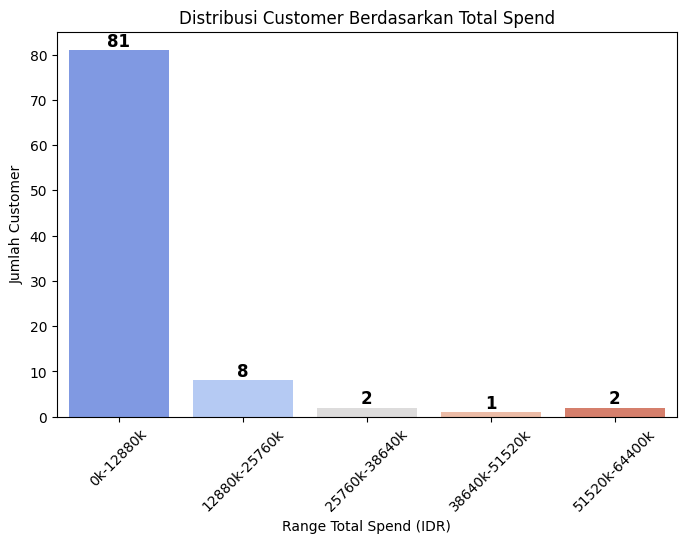

In [136]:
# Buat figure dan plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=spend_distribution.index, y=spend_distribution.values, palette="coolwarm", hue=spend_distribution.index)

# Tambahkan label nominal pada masing-masing batang
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Konfigurasi tampilan
plt.xlabel("Range Total Spend (IDR)")
plt.ylabel("Jumlah Customer")
plt.title("Distribusi Customer Berdasarkan Total Spend")
plt.xticks(rotation=45)
plt.show()

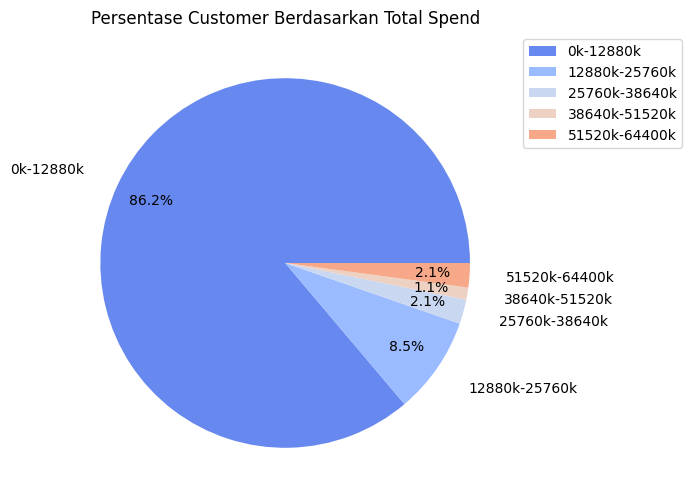

In [137]:
plt.figure(figsize=(6, 6))

# Buat pie chart dengan penyesuaian posisi label
plt.pie(
    spend_distribution, 
    labels=spend_distribution.index, 
    autopct="%1.1f%%",
    colors=sns.color_palette("coolwarm"),
    labeldistance=1.2,  # Memindahkan label lebih jauh dari lingkaran
    pctdistance=0.8  # Memindahkan persentase ke bagian dalam
)

plt.title("Persentase Customer Berdasarkan Total Spend")

# Tambahkan legend agar label tidak saling berdekatan
plt.legend(spend_distribution.index, loc="best", bbox_to_anchor=(1, 1))

plt.show()

### Bubble Chart: Top Produk by Penjualan (by Matthew)

In [65]:
# Ambil 5 produk teratas
df_top5 = merge_bubble.sort_values('total_sales', ascending=False).head(5)

# Scaling ukuran bubble
sizes = (df_top5['total_sales'] / df_top5['total_sales'].max()) * 100 + 40  

# Atur posisi bubble: Buat graph kosong dan layout spring (bubble cloud)
G = nx.Graph()
for i in range(len(df_top5)):
    G.add_node(i)

pos = nx.spring_layout(G, k=0.5, seed=42)  # posisi node dengan spring layout

x_pos = [pos[i][0] for i in range(len(df_top5))]
y_pos = [pos[i][1] for i in range(len(df_top5))]

# Fungsi untuk memformat teks agar setiap baris memiliki maksimal `max_words` kata
def wrap_text(text, max_words=4): 
    words = text.split()
    return "<br>".join([" ".join(words[i:i+max_words]) for i in range(0, len(words), max_words)])

# Buat figure Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_pos,
    y=y_pos,
    mode='markers+text',
    textposition='middle center',
    marker=dict(
        size=sizes,
        color=df_top5['total_sales'],
        colorscale='Viridis',
        showscale=True,
        line=dict(width=2, color='DarkSlateGrey'),
        sizemode='diameter',
        opacity=0.7,
    ),
    hoverinfo='text',
    hovertext=[f"{name}<br>Total Sales: {total:,.0f}" for name, total in zip(df_top5['order_item_name'], df_top5['total_sales'])]
))

annotations = []
for x, y, name, total in zip(x_pos, y_pos, df_top5['order_item_name'], df_top5['total_sales']):
    wrapped_text = wrap_text(name)
    full_text = f"{wrapped_text}<br><b>{int(total):,}</b>"
    annotations.append(dict(
        x=x,
        y=y,
        text=full_text,
        showarrow=False, # Tidak menampilkan panah anotasi
        font=dict(
            color="black",
            size=12,
            family="Arial"
        ),
        align="center",
        xanchor="center",
        yanchor="middle",
        bgcolor="white",
        bordercolor="gray",
        borderwidth=1,
        borderpad=4,
        opacity=0.8
    ))

fig.update_layout(annotations=annotations) # Menambahkan anotasi ke dalam layout grafik

fig.update_layout(
    title="Bubble Cloud Chart: Top 5 Produk by Total Penjualan",
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    plot_bgcolor='white',
    height=600,
    width=800,
    margin=dict(l=20, r=20, t=60, b=20)
)

fig.show()

### Donut Chart: Page dengan interaksi tertinggi (by Hanif)

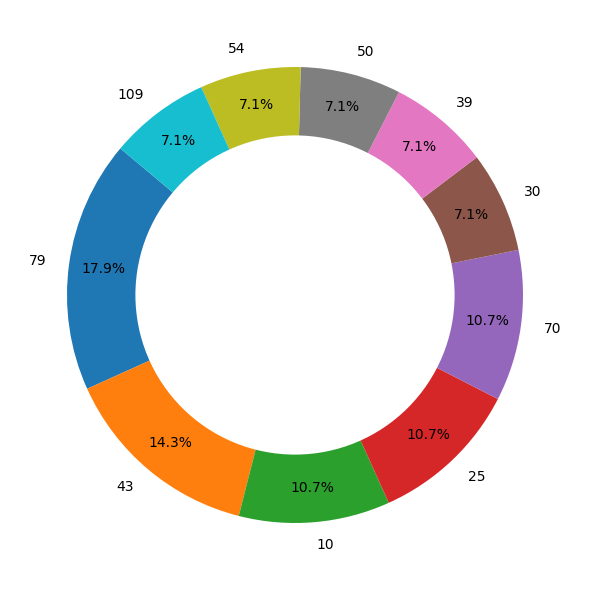

In [104]:
# Buat donut chart
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    top_pages["percentage"],
    labels=top_pages["page"],
    autopct='%1.1f%%',
    startangle=140,
    pctdistance=0.85
)

# Tambahkan lubang di tengah (donut hole)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
ax.add_artist(centre_circle)
plt.tight_layout() # menyesuaikan letak subplot: tidak bertumpuk atau terlalu rapat

### Line Chart: Frekuensi Transaksi by Date (by Nashya)

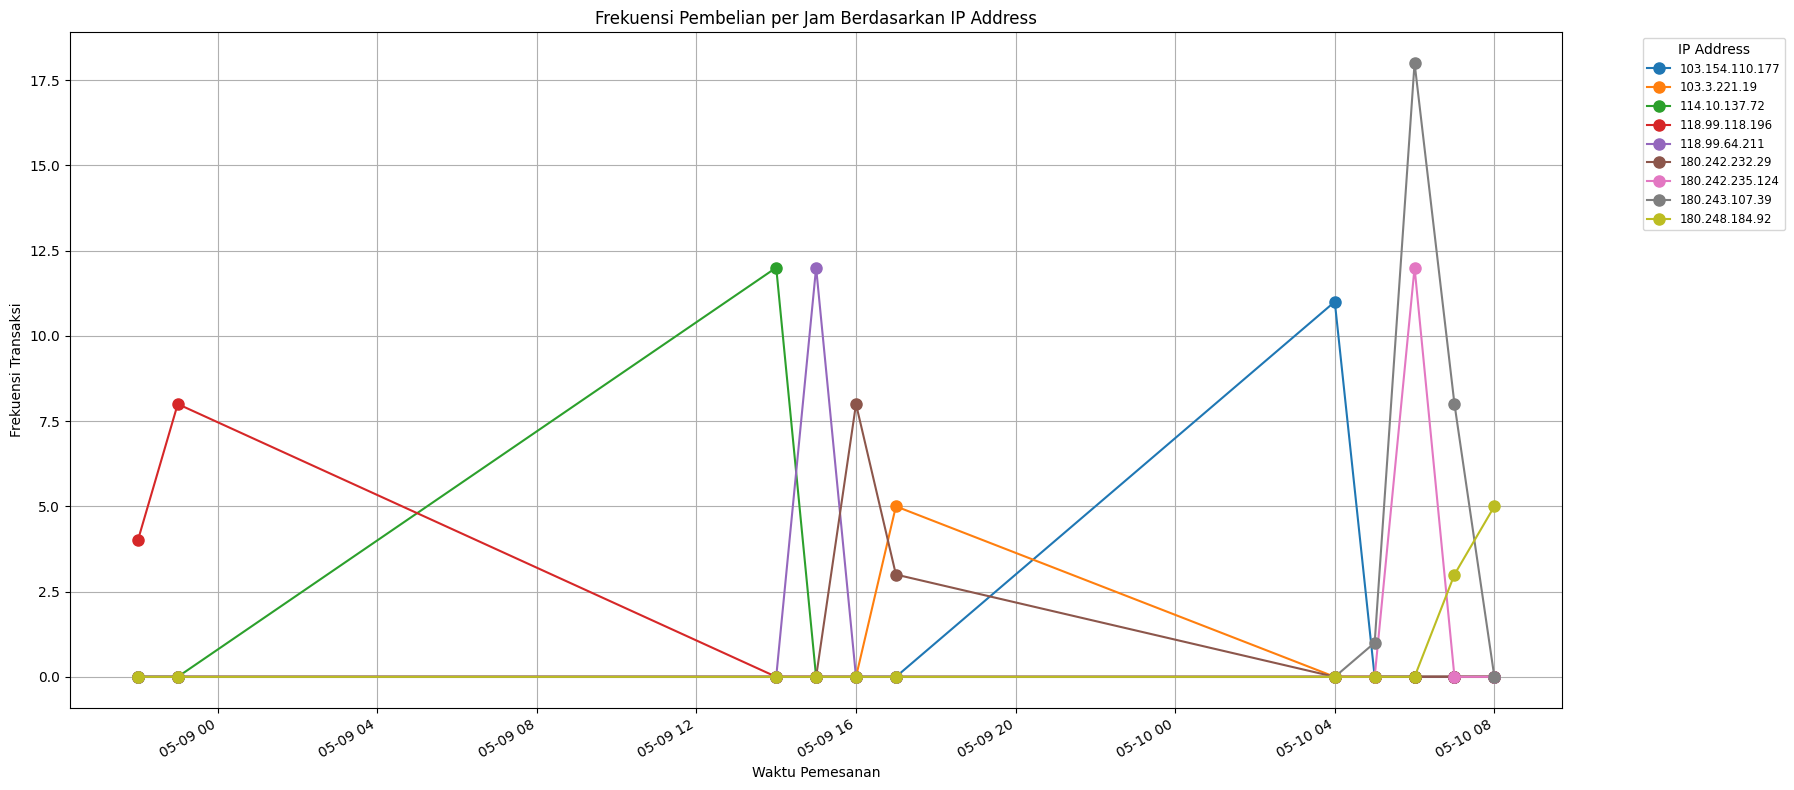

In [169]:
# Plotting
fig, ax = plt.subplots(figsize=(18, 8))
pivot_df.plot(ax=ax, marker='o', markersize=8, linewidth=1.5)
ax.set_title('Frekuensi Pembelian per Jam Berdasarkan IP Address')
ax.set_xlabel('Waktu Pemesanan')
ax.set_ylabel('Frekuensi Transaksi')
ax.legend(title='IP Address', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
ax.grid(True)
plt.tight_layout()

### Bar Chart: Top 10 Produk by Interaksi (by Carsen)

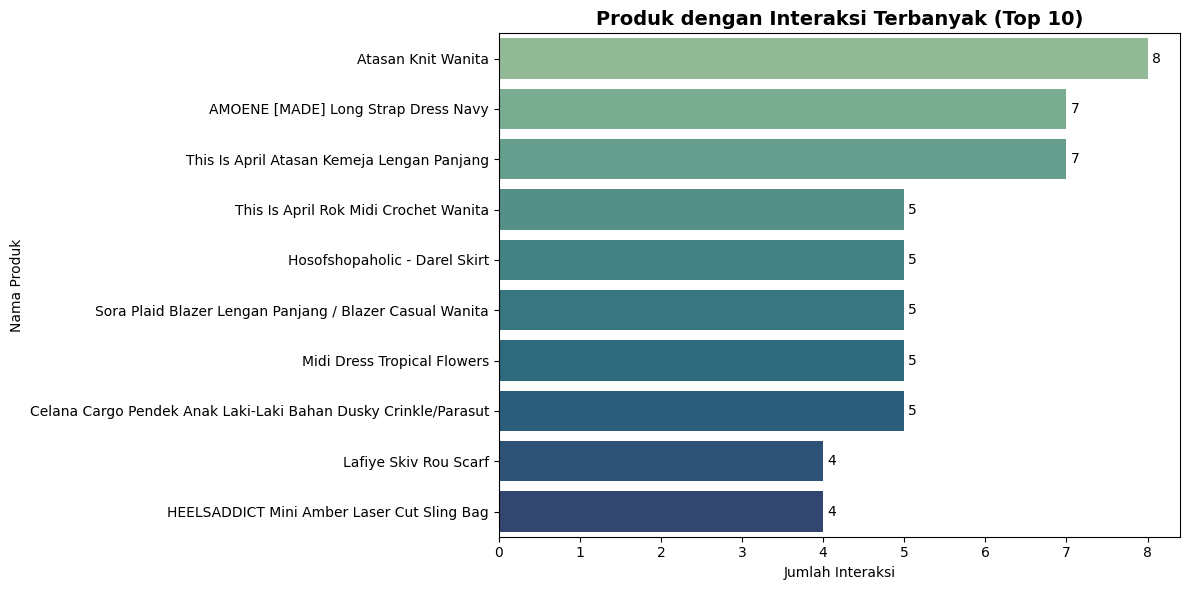

In [175]:
# Visualisasi bar chart horizontal
fig, ax = plt.subplots(figsize=(12, 6))
plot = sns.barplot(
    data=top_products,
    x="interaction_count",
    y="product_name",
    palette="crest",
    hue="product_name",
    legend=False,
    ax=ax
)

for bar in plot.containers:
    plot.bar_label(bar, fmt='%d', label_type='edge', padding=3)

ax.set_title("Produk dengan Interaksi Terbanyak (Top 10)", fontsize=14, fontweight="bold")
ax.set_xlabel("Jumlah Interaksi")
ax.set_ylabel("Nama Produk")
plt.tight_layout()

### Geomap: Pembelian per Kota (by Shafa)

In [8]:
# === PLOT ===
fig = px.scatter_geo(
    city_sales,
    lat='latitude',
    lon='longitude',
    size='transaction_count',
    color_discrete_sequence=['red'],  # Titik warna merah
    hover_name='city',
    hover_data={
        'transaction_count': True,
        'most_bought_product': True,
        'latitude': False,
        'longitude': False
    },
    title='Sebaran Transaksi per Kota',
    projection='mercator'
)

fig.update_geos(
    visible=True,
    lataxis_range=[-11, 6],
    lonaxis_range=[95, 141],
    showcountries=True,
    countrycolor="Black"
)

fig.update_layout(
    margin={"r": 0, "t": 30, "l": 0, "b": 0},
    legend_title_text='Jumlah Transaksi'
)

fig.show()

## Model Asosiasi

### Pengujian Model Asosiasi

In [59]:
product_list = sorted(set(rules["antecedents"].astype(str).apply(eval).explode()))  # Mendapatkan daftar produk unik
selected_products = ['SHOEBALI Heels 021-218', 'Sepatu wanita sneakers']

# # **Inferensi Aturan Asosiasi**
new_transaction = set(selected_products)
matched_rules = rules[rules["antecedents"].astype(str).apply(lambda x: set(eval(x)).issubset(new_transaction))]

# product_list
matched_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
12,(SHOEBALI Heels 021-218),(Sepatu wanita sneakers),0.036364,0.027273,0.018182,0.500000,18.333333,1.0,0.017190,1.945455,0.981132,0.400000,0.485981,0.583333
13,(Sepatu wanita sneakers),(SHOEBALI Heels 021-218),0.027273,0.036364,0.018182,0.666667,18.333333,1.0,0.017190,2.890909,0.971963,0.400000,0.654088,0.583333
14,(SHOEBALI Heels 021-218),(Setelan Jas Dan Celana Pria Formal),0.036364,0.027273,0.018182,0.500000,18.333333,1.0,0.017190,1.945455,0.981132,0.400000,0.485981,0.583333
17,(Sepatu wanita sneakers),(Setelan Jas Dan Celana Pria Formal),0.027273,0.027273,0.018182,0.666667,24.444444,1.0,0.017438,2.918182,0.985981,0.500000,0.657321,0.666667
23,"(SHOEBALI Heels 021-218, Sepatu wanita sneakers)",(Setelan Jas Dan Celana Pria Formal),0.018182,0.027273,0.018182,1.000000,36.666667,1.0,0.017686,inf,0.990741,0.666667,1.000000,0.833333


In [61]:
matched_rules_v2 = matched_rules.copy()
import re # regex
# Fungsi regex untuk menghapus 'frozenset({...})' dan mengonversi ke format list
def clean_frozenset(text):
    cleaned_text = re.sub(r"frozenset\(\{(.*?)\}\)", r"[\1]", text)  # Ubah ke list format string
    return cleaned_text.replace("'", '"')  # Ganti kutip tunggal ke kutip ganda

matched_rules_v2["antecedents"] = matched_rules_v2["antecedents"].apply(lambda x: clean_frozenset(str(x)))
matched_rules_v2["consequents"] = matched_rules_v2["consequents"].apply(lambda x: clean_frozenset(str(x)))

matched_rules_v2.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
12,"[""SHOEBALI Heels 021-218""]","[""Sepatu wanita sneakers""]",0.036364,0.027273,0.018182,0.500000,18.333333,1.0,0.017190,1.945455,0.981132,0.400000,0.485981,0.583333
13,"[""Sepatu wanita sneakers""]","[""SHOEBALI Heels 021-218""]",0.027273,0.036364,0.018182,0.666667,18.333333,1.0,0.017190,2.890909,0.971963,0.400000,0.654088,0.583333
14,"[""SHOEBALI Heels 021-218""]","[""Setelan Jas Dan Celana Pria Formal""]",0.036364,0.027273,0.018182,0.500000,18.333333,1.0,0.017190,1.945455,0.981132,0.400000,0.485981,0.583333
17,"[""Sepatu wanita sneakers""]","[""Setelan Jas Dan Celana Pria Formal""]",0.027273,0.027273,0.018182,0.666667,24.444444,1.0,0.017438,2.918182,0.985981,0.500000,0.657321,0.666667
23,"[""SHOEBALI Heels 021-218"", ""Sepatu wanita snea...","[""Setelan Jas Dan Celana Pria Formal""]",0.018182,0.027273,0.018182,1.000000,36.666667,1.0,0.017686,inf,0.990741,0.666667,1.000000,0.833333


- Jika aturan ditemukan, produk dalam "consequents" bisa direkomendasikan kepada pengguna.
- **Confidence** menunjukkan seberapa besar peluang bahwa orang yang membeli antecedent juga akan membeli consequent.
- **Lift** menunjukkan seberapa kuat hubungan antara antecedent dan consequent dibandingkan pembelian acak.

### Visualisasi Model Asosiasi

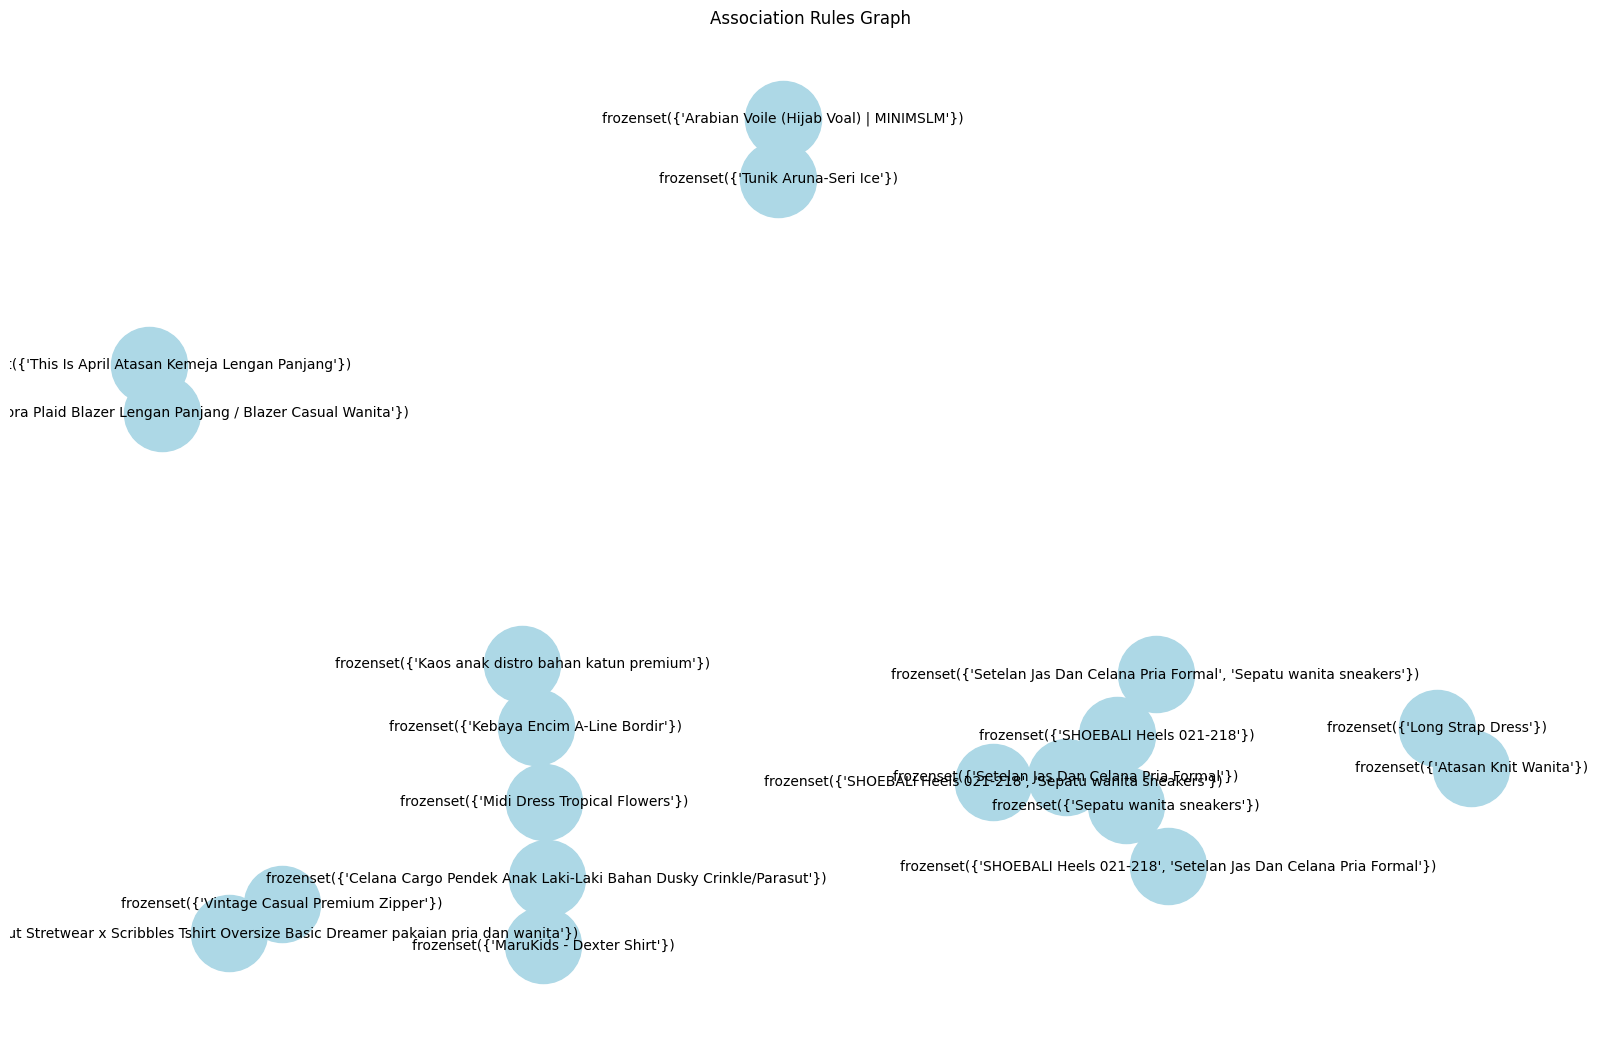

In [62]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_pandas_edgelist(rules, 'antecedents', 'consequents')
plt.figure(figsize=(16, 10))
nx.draw(G, with_labels=True, node_size=3000, node_color='lightblue', font_size=10)
plt.title('Association Rules Graph')
plt.show()

# Deployment

In [ ]:
# Dataset KPI

# Dataset Spend Distribution Chart
# df_spend.to_csv("spend_chart.csv", index=False)


# Dataset Bubble Chart
# merge_bubble.to_csv('bubble_chart.csv', index=False)

# Dataset Donut Chart
# df_page.to_csv("page.csv", index=False)

# Dataset Line Chart
# df_line.to_csv('line_chart.csv', index=False)

# Dataset Interact Chart
# df_interact.to_csv('interact_chart.csv', index=False)


# Dataset Stacked Bar Chart


# Dataset Geomap


# Dataset Model Asosiasi
# rules.to_csv('association_rules.csv', index=False)

# Dataset Model Cluster


# df = pd.read_csv("line_chart.csv")
# df

In [182]:
# Buat dictionary untuk menyimpan data
data_to_save = {
    "ip_options": ip_options,
    "min_date": str(min_date),  # Konversi datetime.date ke string agar bisa disimpan
    "max_date": str(max_date)   # Konversi datetime.date ke string
}

# Simpan sebagai JSON
with open("setup_filter.json", "w") as f:
    json.dump(data_to_save, f, indent=4)